In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import os

from collections import defaultdict
import matplotlib.ticker as mticker


In [ ]:

directories = ['CAHS12', 'CAHS12-dN', 'CAHS12-dC']
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
cutoff = 5.0
stride = 20

results = []

for directory in directories:
    print(f"Processing {directory}...")

    for percent in percentages:
        xtc_path = f'./{directory}/{percent}_md.xtc'
        tpr_path = f'./{directory}/{percent}_md.tpr'

        if not os.path.isfile(xtc_path) or not os.path.isfile(tpr_path):
            print(f"Skipping missing files for {directory} {percent}%")
            continue

        print(f"  → {percent}%")
        u = mda.Universe(tpr_path, xtc_path)

        protein = u.select_atoms("protein")
        lipid_heads = u.select_atoms("resname POPC and name PO4")

        total_frames = 0
        residue_counts = []

        for ts in u.trajectory[::stride]:
            total_frames += 1

            dists = mda.lib.distances.distance_array(protein.positions, lipid_heads.positions)
            close_protein_indices = np.any(dists < cutoff, axis=1)
            nearby_residues = protein[close_protein_indices].residues
            unique_res_ids = set(res.resid for res in nearby_residues)
            residue_counts.append(len(unique_res_ids))
        avg_contacting_residues = np.mean(residue_counts) if residue_counts else 0

        results.append({
            'directory': directory,
            'percent': percent,
            'avg_residues_in_contact': avg_contacting_residues
        })

df_contacts = pd.DataFrame(results)
df_contacts.to_csv("residue_po4_contact_summary.csv", index=False)


In [2]:
import MDAnalysis as mda
import numpy as np
import os
import pandas as pd

directories = ['delta_C', 'delta_N', 'full_cahs12']
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
cutoff = 5.0
stride = 20
MW_protein = 25000  # adjust this value based on actual molecular weight of CAHS12

results = []

for directory in directories:
    print(f"Processing {directory}...")

    for percent in percentages:
        xtc_path = f'./{directory}/{percent}_md.xtc'
        tpr_path = f'./{directory}/{percent}_md.tpr'

        if not os.path.isfile(xtc_path) or not os.path.isfile(tpr_path):
            print(f"Skipping missing files for {directory} {percent}%")
            continue

        print(f"  → {percent}%")
        u = mda.Universe(tpr_path, xtc_path)

        protein = u.select_atoms("protein")
        lipid_heads = u.select_atoms("resname POPC and name PO4")

        box_volumes_ang3 = []

        for ts in u.trajectory[::stride]:

            box_volumes_ang3.append(ts.volume)

        avg_volume_ang3 = np.mean(box_volumes_ang3) if box_volumes_ang3 else 0


        results.append({
            'directory': directory,
            'percent': percent,
            'avg_box_volume_A3': avg_volume_ang3,
        })

df_contacts = pd.DataFrame(results)
df_contacts.to_csv("boxsize.csv", index=False)


Processing delta_C...
  → 10%


/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


  → 20%
  → 30%
  → 40%
  → 50%
  → 60%
  → 70%
  → 80%
  → 90%
Processing delta_N...
  → 10%
  → 20%
  → 30%
  → 40%
  → 50%
  → 60%
  → 70%
  → 80%
  → 90%
Processing full_cahs12...
  → 10%
  → 20%
  → 30%
  → 40%
  → 50%
  → 60%
  → 70%
  → 80%
  → 90%
      directory  percent  avg_box_volume_A3
0       delta_C       10       1.409409e+07
1       delta_C       20       2.102276e+07
2       delta_C       30       2.796468e+07
3       delta_C       40       3.491347e+07
4       delta_C       50       4.186455e+07
5       delta_C       60       4.881305e+07
6       delta_C       70       5.576613e+07
7       delta_C       80       6.271619e+07
8       delta_C       90       6.965328e+07
9       delta_N       10       1.355803e+07
10      delta_N       20       2.056509e+07
11      delta_N       30       2.757255e+07
12      delta_N       40       3.458453e+07
13      delta_N       50       4.159611e+07
14      delta_N       60       4.861409e+07
15      delta_N       70       5.561537e

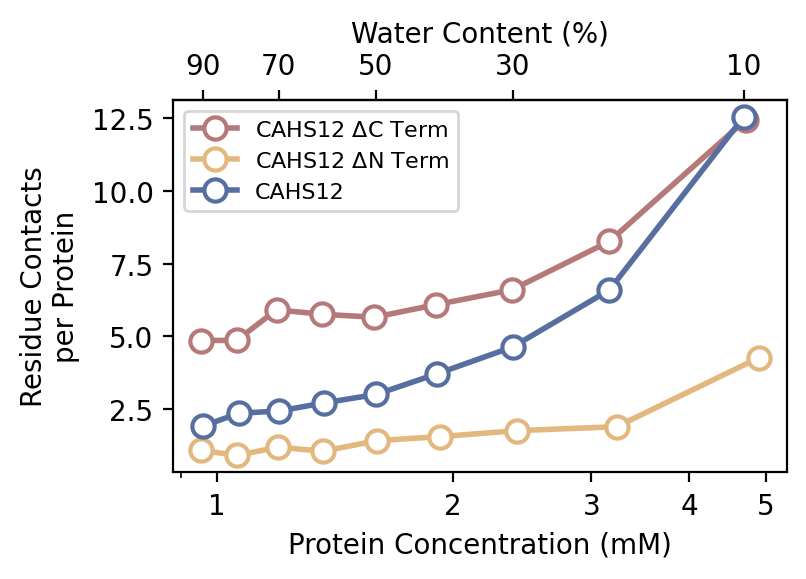

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

df_box = pd.read_csv("boxsize.csv")
df_contacts = pd.read_csv("residue_po4_contact_summary.csv")

plt.figure(figsize=(4, 3), dpi=200)

directories = df_contacts['directory'].unique()
colors = ['#b57979', '#e3b87f','#576fa0']
xnames = ['CAHS12 $\Delta$C Term', r'CAHS12 $\Delta$N Term', r'CAHS12']

#norm_factor = [267,144,297] # per residue
norm_factor = [40,40,40] # per protein

ax = plt.gca()
ax.set_xscale('log')

for i, directory in enumerate(directories):
    subset = df_contacts[df_contacts['directory'] == directory]
    subset_box = df_box[df_box['directory'] == directory]
    plt.plot(
        6.64452E-23*1000/subset_box['avg_box_volume_A3']*1e27,
        subset['avg_residues_in_contact']/norm_factor[i],
        marker='o',
        linewidth=2,
        label=xnames[i],
        color=colors[i % len(colors)],
        markerfacecolor='white',
        markeredgewidth=1.5,
        markersize=8
    )

# Set primary x-axis
plt.xlabel("Protein Concentration (mM)", fontsize=10)
plt.ylabel("Residue Contacts\nper Protein", fontsize=10)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['1', '2', '3', '4', '5'])

water_percent = [90, 80, 70, 60, 50, 40, 30, 20, 10]
protein_conc = [0.95969393, 1.06570793, 1.19804608, 1.36785628, 1.59432285, 
                1.90981001, 2.38130971, 3.16168481, 4.69481661]

secax = ax.secondary_xaxis('top')
secax.set_xscale('log')

secax.set_xticks(protein_conc[::2])
secax.set_xticklabels(water_percent[::2])

secax.xaxis.set_major_locator(ticker.FixedLocator(protein_conc[::2]))
secax.xaxis.set_minor_locator(ticker.NullLocator())

secax.xaxis.set_major_formatter(ticker.ScalarFormatter())
secax.set_xlabel('Water Content (%)', fontsize=10)

secax.set_xticks(protein_conc[::2]) 
secax.set_xticklabels(water_percent[::2])
secax.set_xlabel('Water Content (%)', fontsize=10)


plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('water_del_2.pdf', format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()